In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import concat, lit, regexp_replace, regexp_extract, col, desc
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("Predict Phone Cost").getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxColumnWidth', 1000)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 1000)

In [4]:
dataset_1 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_1.csv", header=True)
dataset_2 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_2.csv", header=True)
dataset_3 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_3.csv", header=True)
dataset_4 = spark.read.format("csv").option("sep", ",").load("datasets/Dataset_4.csv", header=True)

## Подготовка датасетов

In [5]:
# Удаляем столбцы, которые не будем использовать
dataset_1 = dataset_1\
    .withColumn("Phone Name", concat(dataset_1["Brand"], lit(" "), dataset_1["Model"]))\
    .drop("Brand", "Model", "Screen Size")
columns = dataset_1.columns
columns.remove("Phone Name")
columns.insert(0, "Phone Name")
dataset_1 = dataset_1.select(columns)\

# Приводим столбцы к нужному нам виду
dataset_1 = dataset_1\
    .withColumn("Storage", regexp_replace(dataset_1["Storage"], " GB", ""))\
    .withColumn("RAM", regexp_replace(dataset_1["RAM"], " GB", ""))\
    .withColumn("Camera", regexp_extract(dataset_1["Camera"], r"\d+", 0))\
    
# Приведём столбцы к нужному типу
dataset_1 = dataset_1\
    .withColumn("Storage", dataset_1["Storage"].cast("integer"))\
    .withColumn("RAM", dataset_1["RAM"].cast("integer"))\
    .withColumn("Camera", dataset_1["Camera"].cast("integer"))\
    .withColumn("Battery Capacity", dataset_1["Battery Capacity"].cast("integer"))\
    .withColumn("Price", dataset_1["Price"].cast("integer"))\
    .withColumn("Price", col("Price") * 80)\
    .withColumnRenamed("Battery Capacity", "Battery")

In [6]:
dataset_1.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [7]:
# Удаляем лишние столбцы и сокращаем названия
dataset_2 = dataset_2\
    .withColumnRenamed("Brand me", "Phone Name")\
    .withColumnRenamed("ROM", "Storage")\
    .withColumnRenamed("Primary_Cam", "Camera")\
    .withColumnRenamed("Battery_Power", "Battery")\
    .drop("Ratings", "Unnamed: 0", "Mobile_Size", "Selfi_Cam")

# Переопределяем типы у столбцов
dataset_2 = dataset_2\
    .withColumn("RAM", dataset_2["RAM"].cast("integer"))\
    .withColumn("Storage", dataset_2["Storage"].cast("integer"))\
    .withColumn("Camera", dataset_2["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_2["Battery"].cast("integer"))\
    .withColumn("Price", dataset_2["Price"].cast("integer"))

# Создаём удобный порядок столбцов
columns_2 = dataset_2.columns
columns_2.remove("RAM")
columns_2.remove("Storage")
columns_2.insert(1, "Storage")
columns_2.insert(2, "RAM")
dataset_2 = dataset_2.select(columns_2)

In [8]:
dataset_2.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [9]:
# Удаляем лишние столбцы
dataset_3 = dataset_3\
    .drop("Rating ?/5", "Number of Ratings", "Processor", "Date of Scraping", "Front Camera")\
    .withColumnRenamed("ROM/Storage", "Storage")\
    .withColumnRenamed("Back/Rare Camera", "Camera")\
    .withColumnRenamed("Back/Rare Camera", "Battery")\
    .withColumnRenamed("Price in INR", "Price")

# Удаляем из строк лишние данные
dataset_3 = dataset_3\
    .withColumn("RAM", regexp_replace(dataset_3["RAM"], " GB RAM", ""))\
    .withColumn("Storage", regexp_replace(dataset_3["Storage"], " GB ROM", ""))\
    .withColumn("Battery", regexp_replace(dataset_3["Battery"], " mAh", ""))\
    .withColumn("Price", regexp_replace(regexp_replace(dataset_3["Price"], "₹", ""), ",", ""))\
    .withColumn("Camera", regexp_extract(dataset_3["Camera"], r"\d+", 0))\

# Меняем местами столбцы для нужного нам порядка
columns_3 = dataset_3.columns
columns_3.remove("RAM")
columns_3.remove("Storage")
columns_3.insert(1, "Storage")
columns_3.insert(2, "RAM")
dataset_3 = dataset_3.select(columns_3)

# Переопределяем типы у столбцов
dataset_3 = dataset_3\
    .withColumn("Storage", dataset_3["Storage"].cast("integer"))\
    .withColumn("RAM", dataset_3["RAM"].cast("integer"))\
    .withColumn("Camera", dataset_3["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_3["Battery"].cast("integer"))\
    .withColumn("Price", (dataset_3["Price"] * 1.1).cast("integer"))\
    

In [10]:
dataset_3.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [11]:
columns_4 = ["Name", "Internal storage (GB)", "RAM (MB)", "Rear camera", "Battery capacity (mAh)","Price"]
dataset_4 = dataset_4.select(columns_4)
dataset_4 = dataset_4.withColumnRenamed("Battery capacity (mAh)", "Battery")\
    .withColumnRenamed("RAM (MB)", "RAM")\
    .withColumnRenamed("Internal Storage (GB)", "Storage")\
    .withColumnRenamed("Rear camera", "Camera")\
    .withColumnRenamed("Name", "Phone Name")

dataset_4 = dataset_4.withColumn("RAM", (dataset_4["RAM"] / 1000).cast("integer"))\
    .withColumn("Storage", dataset_4["Storage"].cast("integer"))\
    .withColumn("Camera", dataset_4["Camera"].cast("integer"))\
    .withColumn("Battery", dataset_4["Battery"].cast("integer"))\
    .withColumn("Price", dataset_4["Price"].cast("integer"))

In [12]:
dataset_4.printSchema()

root
 |-- Phone Name: string (nullable = true)
 |-- Storage: integer (nullable = true)
 |-- RAM: integer (nullable = true)
 |-- Camera: integer (nullable = true)
 |-- Battery: integer (nullable = true)
 |-- Price: integer (nullable = true)



In [13]:
# Объединим теперь наши датасеты в один
dataset_union = dataset_1.union(dataset_2).union(dataset_3).union(dataset_4).dropDuplicates(["Phone Name"]).na.drop()

In [14]:
# Создадим вектор фич для матрицы корреляций
corr_features = [x for x in dataset_union.columns if x != "Phone Name"]
print(corr_features)
corr_assem = VectorAssembler(inputCols=corr_features, outputCol="features")
feature_vector_corr = corr_assem.transform(dataset_union)
feature_vector_corr

['Storage', 'RAM', 'Camera', 'Battery', 'Price']


Phone Name,Storage,RAM,Camera,Battery,Price,features
Oppo F19 Pro+ 5G,128,8,64,4310,31920,"[128.0,8.0,64.0,4310.0,31920.0]"
Xiaomi Redmi Note 10S,128,6,64,5000,18320,"[128.0,6.0,64.0,5000.0,18320.0]"
Motorola Moto G Stylus (2021),128,4,48,4000,23920,"[128.0,4.0,48.0,4000.0,23920.0]"
Nokia 6.2,128,4,16,3500,19920,"[128.0,4.0,16.0,3500.0,19920.0]"
Samsung Galaxy S21+ 5G,256,8,12,4800,79920,"[256.0,8.0,12.0,4800.0,79920.0]"
Realme Narzo 50i,32,2,50,5000,7920,"[32.0,2.0,50.0,5000.0,7920.0]"
Samsung Galaxy A52s 5G,128,6,64,4500,35920,"[128.0,6.0,64.0,4500.0,35920.0]"
Oppo A94 5G,128,8,48,4310,31920,"[128.0,8.0,48.0,4310.0,31920.0]"
Oppo Reno 5 Pro 5G,128,8,64,4350,35920,"[128.0,8.0,64.0,4350.0,35920.0]"
Oppo A94,128,8,48,4310,30320,"[128.0,8.0,48.0,4310.0,30320.0]"


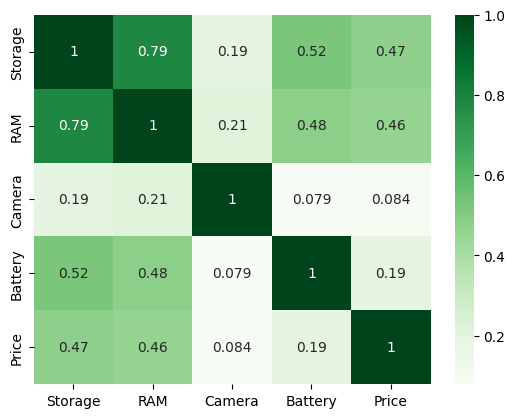

In [15]:
# Построим матрицу корреляций
matrix = Correlation.corr(feature_vector_corr, "features").collect()[0][0].toArray()
sns.heatmap(matrix, xticklabels=corr_features, yticklabels=corr_features, cmap="Greens", annot=True)
plt.show()

##### Видим, что взаимосвязь между "ценой" и "камерой" не такая высокая, но пока что оставим данную фичу для обучения и посмотрим на ошибку модели.

In [16]:
# Создаим список фич в один векторный столбец
features = ["Storage", "RAM", "Battery"]
feature = VectorAssembler(inputCols=features, outputCol="features")
feature_vector = feature.transform(dataset_union)

In [37]:
# Разделим датасет на два: тренировочный и тестовый.
train_df, test_df = feature_vector.filter(feature_vector["Price"] < 200000).randomSplit([0.8, 0.2], seed=42)

In [40]:
train_df.select("Price").orderBy(col("Price").desc())

Price
174990
164999
159920
153000
148498
148498
140300
140300
137498
137498


In [41]:
test_df.select("Price").orderBy(col("Price").desc())

Price
112450
111920
103920
103000
93498
92999
87998
87998
87920
87920


In [20]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="Price", featuresCol="features")
model = gbt.fit(train_df)
pred = model.transform(test_df)

In [21]:
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")

In [22]:
lr_accuracy = evaluator.evaluate(pred)
lr_accuracy

7280.632715347098

In [23]:
# paramGrid = ParamGridBuilder() \
#     .addGrid(gbt.maxIter, [10, 20, 30])\
#     .addGrid(gbt.maxDepth, [3, 4, 5])\
#     .build()

# paramGrid

In [24]:
# crossval = CrossValidator(estimator=gbt,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=evaluator,
#                           numFolds=3)

# cv_model = crossval.fit(train_df)
# cv_model.avgMetrics